Number of Omega-automaton states (including the trap state): 44
Number of accepting pairs: 1


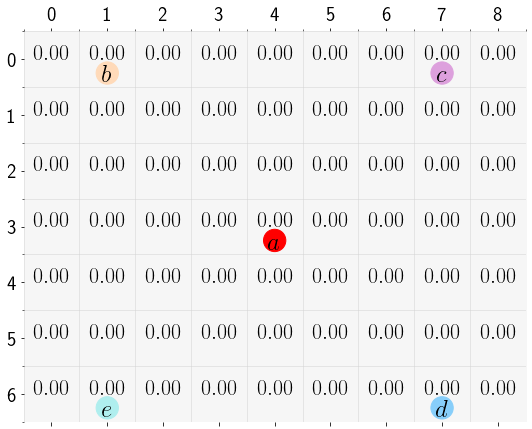

In [1]:
%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import pickle

# Specification
phi_det = 'F(u & Xu & ((XXm & XXXFm) | (XXXm & XXXXFm)))'
phi_obj = '(F(b & F(c & F(d & Fe))) & G!a)'
ltl = phi_det +' | ' + phi_obj

oa = OmegaAutomaton(ltl,oa_type='dra')
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
print('Number of accepting pairs:',oa.shape[0])
display(oa)

# MDP Description
shape = (7,9)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E',  'E',  'E',  'E',  'E']
])

label = np.array([
    [(),        ('b',),    (),        (),        (),        (),        (),        ('c',),    ()],
    [(),        (),        (),        (),        (),        (),        (),        (),        ()],
    [(),        (),        (),        (),        (),        (),        (),        (),        ()],
    [(),        (),        (),        (),        ('a',),    (),        (),        (),        ()],
    [(),        (),        (),        (),        (),        (),        (),        (),        ()],
    [(),        (),        (),        (),        (),        (),        (),        (),        ()],
    [(),        ('e',),    (),        (),        (),        (),        (),        ('d',),    ()]
],dtype=np.object)

reward = np.zeros(shape)

lcmap={
    'b':'peachpuff',
    'c':'plum',
    'd':'lightskyblue',
    'e':'paleturquoise',
    'a':'red'
}

grid_mdp = GridMDP(shape=shape,structure=structure,reward=reward,label=label,figsize=9,secure=True,lcmap=lcmap)  # Use figsize=4 for smaller figures
grid_mdp.plot()
# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa,discount=0.999,discountB=0.99,discountC=0.9)

In [2]:
# Q=csrl.minimax_q(T=2**10,K=2**20)
Q = np.load('sequencing_Q.npy')
with open('sequencing_csrl.pkl','rb') as f:
    csrl = pickle.load(f)

In [10]:
np.sum(value)

62.999999999998956

In [3]:
policy = np.argmax(np.min(Q,axis=-1),axis=-1)
policy_ = np.take_along_axis(np.argmin(Q,axis=-1),np.expand_dims(policy,axis=-1),axis=-1).reshape(policy.shape)

value = np.max(np.min(Q,axis=-1),axis=-1)
_value = np.copy(value)
_policy = np.copy(policy)
_value[:] = np.max(value,axis=0)
_policy[:] = np.argmax(value,axis=0)

ind = (csrl.discountC*_value) > value
policy[ind] = _policy[ind] + len(csrl.mdp.A)
csrl.plot(value=value,policy=policy,policy_=policy_)

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=43),…

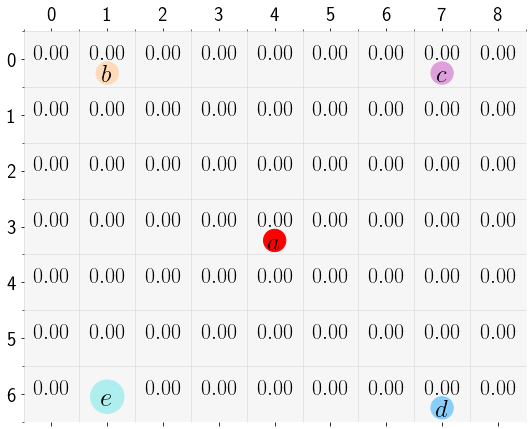

In [4]:
csrl.plot(value=value,iq=(0,8),hidden=[(6,1)],save='safe_sequence_d_to_e.pdf')

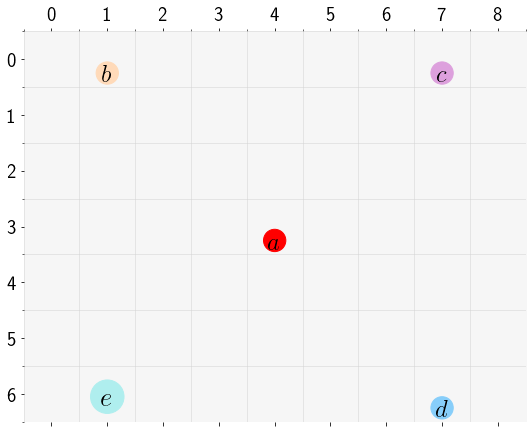

In [5]:
csrl.plot(value=value,policy=policy,policy_=policy_,iq=(0,9),hidden=[(6,1)],save='safe_sequence_d_to_e_1.pdf')

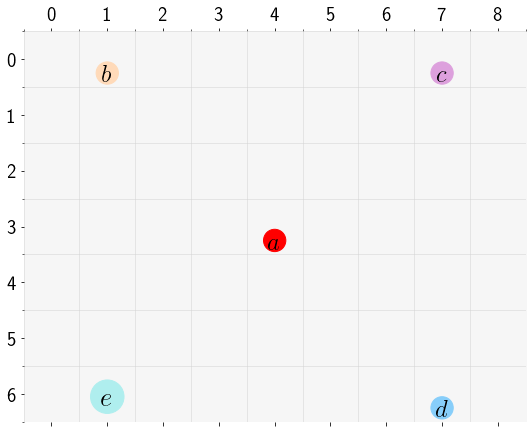

In [6]:
csrl.plot(value=value,policy=policy,policy_=policy_,iq=(0,30),hidden=[(6,1)],save='safe_sequence_d_to_e_2.pdf')

In [7]:
episode=csrl.simulate(policy,policy_,value=value,start=(0,0),T=500)

interactive(children=(IntSlider(value=0, description='t', max=499), Output()), _dom_classes=('widget-interact'…

In [8]:
# # np.save('robust_episode',np.array(episode))
# import os
# import matplotlib.pyplot as plt
# pad=5
# animation='test'
# # T=1000
# # if not os.path.exists(animation):
# #     os.makedirs(animation)
# # for t in range(T):
# #     csrl.mdp.plot(value=value[episode[t][:2]],policy=policy[episode[t][:2]],policy_=policy_[episode[t][:2]],agent=episode[t][2:],save=animation+os.sep+str(t).zfill(pad)+'.png',title='Time: '+str(t)+',  Accepting Pair: '+str(episode[t][0]+1)+',  DRA State (Mode): '+str(episode[t][1]))
# #     plt.close()
# os.system('ffmpeg -r 5 -i '+animation+os.sep+'%0'+str(pad)+'d.png -vcodec libx264 -y '+animation+'.mp4')